# Computación Científica - Tarea 2
---
Vicente Lizana Estivill  
vlizana@alumnos.inf.utfsm.cl  
201310004-K

---

## Introducción
---



En este trabajo se busca aprender acerca de la pérdida de presición que puede existir en caso de que uno no posea conciencia de como la arquitectura implementa las representaciones de los números con los que uno trabaja. Veremos como trabajan los computadores y como y cuando influye la pérdida de significancia a la hora de operar con cantidades de diferentes magnitudes.

## Desarrollo y Análisis de Resultados
---

### Bibliotecas y Utilidades
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import bitstring as bs

In [2]:
def to_binary(f):
    b = bs.pack('>d', f)
    b = b.bin
    return(b[0] + ' ' + b[1:12] + ' ' + b[12:])

def bin_shift(f_string, shift):
    f_string = to_binary(f_string)
    f = f_string.split()
    f[1] = bin(int(f[1],2) + shift)[2:]
    f[2] = bin(int('1'+f[2],2) >> shift)[2:].rjust(52, '0')
    return ' '.join(f)

### Aritmética de Punto Flotante
---

a) Defina que corresponde el valor de <b>machine epsilon</b> $\epsilon_{mach}$ y explique porqué es posible obtener dicho valor en una computadora IEEE de doble precisión calculando el valor de la siguiente resta:

$$\left(\frac{7.0}{3.0} - \frac{4.0}{3.0}\right) - 1.0 $$

Implemente la resta usando variables de doble precisión y describa el procedimiento usando aritmética de doble precisión y Nearest Rounding Rule
___

- Machine Epsilon ($\epsilon_{mach}$) corresponde al menor incremento posible a $1$ que resulta ser representable por la arquitectura.

- Podemos ver por que existe un $\epsilon_{mach}$ de error en esta resta mirando las representaciones de los flotantes en juego:

In [3]:
print(to_binary(7.0/3.0))
print(to_binary(4.0/3.0))

0 10000000000 0010101010101010101010101010101010101010101010101011
0 01111111111 0101010101010101010101010101010101010101010101010101


Para hacer la resta, el computador debe hacer un _shift_ a la mantisa del número menor, equiparando los exponentes. Notemos que el menor queda subnormal, a pesar de que el exponente tiene unos.

In [4]:
print(to_binary(7.0/3.0), '- 0')
print(bin_shift(4.0/3.0, 1), '- 1')
print('- '+'-'*11+' '+'-'*52)
subt = to_binary(0).split()
subt[1] = '1' + subt[1][1:]
subt[2] = '1' + subt[2][1:]
print(' '.join(subt), '- 1')

0 10000000000 0010101010101010101010101010101010101010101010101011 - 0
0 10000000000 1010101010101010101010101010101010101010101010101010 - 1
- ----------- ----------------------------------------------------
0 10000000000 1000000000000000000000000000000000000000000000000000 - 1


Esto nos entrega un número que todavía está en representación subnormal, para normalizarlo volvemos implícito el primer uno de la mantisa.

In [5]:
print(to_binary(7.0/3.0 - 4.0/3.0))

0 01111111111 0000000000000000000000000000000000000000000000000001


Lo que claramente entrega $1+\epsilon_{mach}$. Nearest Rounding Rule se utilizó para transformar a binario los primeros términos, lo que originó el error de aproximación.

In [6]:
e_mach = (7.0/3.0 - 4.0/3.0) - 1.0
print('e_mach =', e_mach)

e_mach = 2.220446049250313e-16


---

b) Considere la serie geométrica:

$$\sum_{i=0}^{\infty} r^i = \frac{1}{1-r}$$ 

para $|r|<1$. Ahora considere el siguiente código.

In [7]:
# Suma parcial de serie geométrica.
# Esta función realiza una suma parcial de la serie geométrica con M terminos, 
# pero detecta si es que los terminos que se están agregando aportan o no al
# resultado final. En caso de que los terminos ya no aporten, se detiene el loop
# y se retorna el valor obtenido y el índice en que se detuvo el loop.

def my_partial_geometric_series(r,M):
    sum_final=1.0
    sum_before=sum_final
    final_index=-1
    for i in np.arange(1,M):
        sum_before +=r**i
        if sum_final==sum_before:
            final_index=i-1
            break
        else:
            sum_final=sum_before
    # Se retorna el valor obtenido de la suma parcial y cuando se truncó
    # dado que no aportaba.
    return np.array([sum_final,final_index])

Ahora para distintos valores de $r$ se han obtenido el número de terminos que efectivamente aportan al resultado final dado que se está utilizando _double precision_.

In [8]:
N = 20
M = 1e8
r_all = np.logspace(-1,-20,N)
out_data = np.zeros((N,2))
for i in np.arange(N):
    out_data[i,:]=my_partial_geometric_series(r_all[i],M)

Graficando la candidad de terminos significativos en _double precision_ versus el $r$.

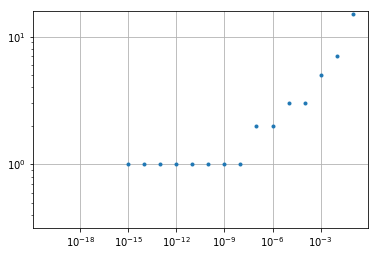

In [9]:
plt.figure()
plt.loglog(r_all,out_data[:,1],'.')
plt.grid(True)
plt.ylim([10**(-0.5),np.max(out_data[:,1])+1])
plt.show()

Explique cláramente por qué a medida que disminuye $r$ disminuye la cantidad de terminos significativos obtenidos.

---

Tenemos que los términos de la serie ya no aportan cuando $n$ satisface la siguiente inecuación:

$$ \frac{\epsilon_{mach}}{2} \cdot \sum_{i=0}^{n-1} r^i > r^n $$

es decir

$$ \frac{\epsilon_{mach}}{2} \cdot \frac{1-r^n}{1-r} > r^n $$

despejando $n$

$$ n < \log_r(\epsilon_{mach}) - \log_r(2 - 2r + \epsilon_{mach}) $$

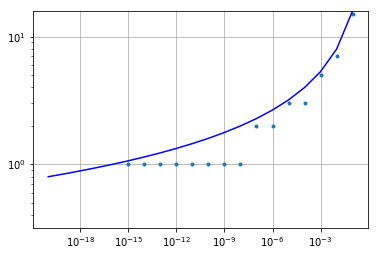

In [10]:
n = lambda x: (np.log(e_mach) - np.log(2-2*x+e_mach)) / np.log(x)
n_values = n(r_all)

plt.figure()
plt.loglog(r_all,out_data[:,1],'.')
plt.grid(True)
plt.ylim([10**(-0.5),np.max(out_data[:,1])+1])
plt.plot(r_all, n_values, 'b-')
plt.show()

Podemos ver que la cantidad de términos significativos es una función discreta que corresponde a la función piso de esta curva. A fin de cuentas lo que está pasando es que a medida que disminuye $r$ el $\epsilon_{mach}$ relativo crece más rápido debido al comportamiento que describe la inecuación, restando significancia a los términos siguientes y por lo tanto disminuyendo el número de iteraciones.

---

c) Explique la razón de por qué el loop indicado debe ejecutar el break. Utilice la función "to_binary" incluida en el jupyter notebook "03_floating_point_arithmetic" para entregar su justificación. Obtenga el menor valor de $X$ que ejecuta el break.

In [ ]:
# Hint: Comenzando con X=1.0 se demorará mucho, piense primero, determine un buen X y luego ejecute el código.
X=1.0
a=X+0.0
b=X+1.0
while(True):
    a+=1.0
    b+=1.0
    if a == b:
        print('They are equal! Why?')
        break

---

Dado cualquier número, se irá incrementando hasta que en algún momento la mitad del $\epsilon_{mach}$ relativo será más grande que el incremento (en este caso 1). Esto que provocará que al sumar uno, el número representable más cercano sea el mismo y se ejecute el break.

Lo podemos apreciar poniendo un número grande:

In [11]:
X=1e20
print('x = ', to_binary(X))
print('1 = ', to_binary(1.0))
a=X+0.0
b=X+1.0
while(True):
    print('Iteration!')
    a+=1.0
    b+=1.0
    if a == b:
        print('They are equal! Why?')
        break

x =  0 10001000001 0101101011110001110101111000101101011000110001000000
1 =  0 01111111111 0000000000000000000000000000000000000000000000000000
Iteration!
They are equal! Why?


Al realizar la suma, el 1 pierde toda su significancia:

In [12]:
print(' ', to_binary(X))
one = to_binary(0).split()
one[1] = to_binary(X).split()[1]
one.append('00...01')
print('+', ' '.join(one), '(subnormal)')
print('  - '+'-'*11+' '+'-'*52)
print(' ', to_binary(X))

  0 10001000001 0101101011110001110101111000101101011000110001000000
+ 0 10001000001 0000000000000000000000000000000000000000000000000000 00...01 (subnormal)
  - ----------- ----------------------------------------------------
  0 10001000001 0101101011110001110101111000101101011000110001000000


Para obtener el menor valor de $X$ que ejecuta el break debemos encontrar 2 numeros consecutivos que cumplan que uno de ellos no lo ejecute y el otro si. Como se mencionó, un numero ejecuta el break si la mitad del $\epsilon_{mach}$ relativo es más grande que el incremento.

Tenemos entonces el siguiente sistema:

$$ x + 1 > x + x \cdot \frac{\epsilon_{mach}}{2} $$
$$ y + 1 < y + y \cdot \frac{\epsilon_{mach}}{2} $$
$$ x + x \cdot \epsilon_{mach} = y $$

Reemplazando y despejando podemos acotar $x$ en:

$$ x < \frac{2}{\epsilon_{mach}} $$

$$ x > \frac{2}{\epsilon_{mach} + \epsilon_{mach}^2} $$

In [13]:
upper = 2 / e_mach
lower = 2 / (e_mach + e_mach ** 2)
print('x <', upper, '->', to_binary(upper))
print('x >', lower, '->', to_binary(lower))

x < 9007199254740992.0 -> 0 10000110100 0000000000000000000000000000000000000000000000000000
x > 9007199254740990.0 -> 0 10000110011 1111111111111111111111111111111111111111111111111110


Entonces el menor número que rompe el ciclo es $x = 9007199254740991$

In [14]:
X=lower
print('x =', to_binary(X))
a=X+0.0
b=X+1.0
while(True):
    print('First iteration!')
    a+=1.0
    b+=1.0
    if a == b:
        print('They are equal! Why?\n')
        break

X=lower+1
print('x =', to_binary(X))
a=X+0.0
b=X+1.0
while(True):
    print('Second iteration!')
    a+=1.0
    b+=1.0
    if a == b:
        print('They are equal! But it has been explained why.')
        break

x = 0 10000110011 1111111111111111111111111111111111111111111111111110
First iteration!
First iteration!
They are equal! Why?

x = 0 10000110011 1111111111111111111111111111111111111111111111111111
Second iteration!
They are equal! But it has been explained why.


---

### Pérdida de Significancia:
---

#### 1. Dada la función:

$$f(x) = \frac{1 - x}{ 1 + x} - \frac{1}{3x+1}$$

a) Grafique la función usando $x \in {[-10,10]}$ ¿Para que valores de x la función queda reducida a $0$ ?

---

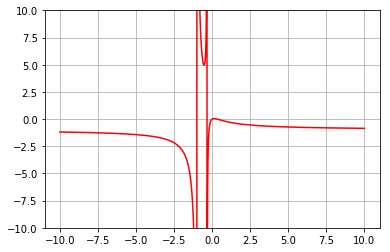

In [15]:
f = lambda x: (( 1-x )/( 1+x )) - (( 1 )/( 3*x+1 ))
set_x = np.linspace(-10, 10, 10000)
set_y = f(set_x)

plt.plot(set_x, set_y, 'r-')
plt.grid()
plt.ylim(-10,10)
plt.show()

Podemos ver mejor los ceros si nos acercamos al área de interés.

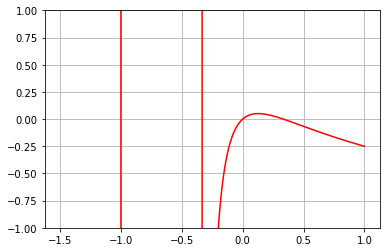

In [16]:
set_x = np.linspace(-1.5, 1, 10000)
set_y = f(set_x)

plt.plot(set_x, set_y, 'r-')
plt.grid()
plt.ylim(-1,1)
plt.show()

Analíticamente la función tiene ceros en $x=0$ y $x=\frac{1}{3}$ y discontinuidades en $x=-\frac{1}{3}$ y $x=-1$.

---

b) Usando $x = [10^{-1} , 10^{-2} , ... , 10^{-20}] $ , calcule los valores de $f(x)$ ¿Que ocurre con los valores observados? ¿En que momento ocurre pérdida de significancia? Describa el origen de cancelación de digítos. 

---

In [17]:
logset_x = np.logspace(-2, -21, 20)
print(f(logset_x))

[  9.32423339e-03   9.93024921e-04   9.99300250e-05   9.99930002e-06
   9.99993000e-07   9.99999299e-08   9.99999938e-09   9.99999972e-10
   1.00000008e-10   1.00000008e-11   9.99977878e-13   1.00031095e-13
   9.99200722e-15   9.99200722e-16   1.11022302e-16   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]


Se observa que en los últimos términos se pierde la significancia. Para ver por que ocurre revisamos los términos que influyen para $x$ pequeño.

In [18]:
x = 1e-16
print('     x :', to_binary(x))
print(' 1 - x :', to_binary(1-x))
print(' 1 + x :', to_binary(1+x))
print('     1 :', to_binary(1))
print('3x + 1 :', to_binary(3*x+1))
print()
print(' 1-x / 1+x :', to_binary((1-x)/(1+x)))
print('1 / 3x + 1 :', to_binary((1)/(3*x+1)))
print()

print('-'*80, end='\n\n')

x = 1e-17
print('     x :', to_binary(x))
print(' 1 - x :', to_binary(1-x))
print(' 1 + x :', to_binary(1+x))
print('     1 :', to_binary(1))
print('3x + 1 :', to_binary(3*x+1))
print()
print(' 1-x / 1+x :', to_binary((1-x)/(1+x)))
print('1 / 3x + 1 :', to_binary((1)/(3*x+1)))

     x : 0 01111001001 1100110100101011001010010111110110001000100110111100
 1 - x : 0 01111111110 1111111111111111111111111111111111111111111111111111
 1 + x : 0 01111111111 0000000000000000000000000000000000000000000000000000
     1 : 0 01111111111 0000000000000000000000000000000000000000000000000000
3x + 1 : 0 01111111111 0000000000000000000000000000000000000000000000000001

 1-x / 1+x : 0 01111111110 1111111111111111111111111111111111111111111111111111
1 / 3x + 1 : 0 01111111110 1111111111111111111111111111111111111111111111111110

--------------------------------------------------------------------------------

     x : 0 01111000110 0111000011101111010101000110010001101101010010010111
 1 - x : 0 01111111111 0000000000000000000000000000000000000000000000000000
 1 + x : 0 01111111111 0000000000000000000000000000000000000000000000000000
     1 : 0 01111111111 0000000000000000000000000000000000000000000000000000
3x + 1 : 0 01111111111 0000000000000000000000000000000000000000000000000

Como se puede ver, para $x$ suficientemente pequeño todos los términos se aproximan a 1, el origen de la cancelación es que el 1 es demasiado significante y al sumarle o restarle números del orden de magnitud de $x$ se mantiene inalterado.

La pérdida total de significancia ocurre cuando se cumple uno de los siguientes casos:

$$ \frac{1}{3x+1} > 1 - \frac{\epsilon_{mach}}{2} \Rightarrow x < \frac{\epsilon_{mach}}{6-3\epsilon_{mach}} $$

$$ \frac{1-x}{1+x} > 1 - \frac{\epsilon_{mach}}{2} \Rightarrow x < \frac{\epsilon_{mach}}{4-\epsilon_{mach}} $$

el primer caso entrega un $x$ mayor, por lo que ese es el que sirve, solo hay que agregar un $\epsilon_{mach}$ relativo.

In [19]:
x = (e_mach + e_mach ** 2) / (6 - 3 * e_mach)
print('     x :', to_binary(x))
print(' 1 - x :', to_binary(1-x))
print(' 1 + x :', to_binary(1+x))
print('     1 :', to_binary(1))
print('3x + 1 :', to_binary(3*x+1))
print()
print(' 1-x / 1+x :', to_binary((1-x)/(1+x)))
print('1 / 3x + 1 :', to_binary((1)/(3*x+1)))
print('\nmomento de pérdida de significancia: x =', x)

x = (e_mach) / (6 - 3 * e_mach)
print('\nf(x) sin agregarle e_mach relativo:', (1-x)/(1+x) - (1)/(3*x+1))

     x : 0 01111001000 0101010101010101010101010101010101010101010101011000
 1 - x : 0 01111111111 0000000000000000000000000000000000000000000000000000
 1 + x : 0 01111111111 0000000000000000000000000000000000000000000000000000
     1 : 0 01111111111 0000000000000000000000000000000000000000000000000000
3x + 1 : 0 01111111111 0000000000000000000000000000000000000000000000000001

 1-x / 1+x : 0 01111111111 0000000000000000000000000000000000000000000000000000
1 / 3x + 1 : 0 01111111110 1111111111111111111111111111111111111111111111111110

momento de pérdida de significancia: x = 3.70074341541719e-17

f(x) sin agregarle e_mach relativo: 0.0


---

c) Reescriba la función original para evitar el proceso de pérdida de significancia (hint: busqué un denominador común para ambas fracciones.)

---

Al buscar un común denominador la función se transforma en la siguiente:

$$ f(x) = \frac{x-3x^2}{3x^2+4x+1} $$

Esto evita que el numerador sea absorbido por uno y disminuye considerablemente la pérdida de significancia.

---

d) Analice la diferencia entre los resultados de la función $f(x)$ con la función reescrita en la pregunta anterior. Realice un gráfico que mida la diferencia entre los resultados del punto a) y c). Realice un análisis cualitativo y cuantitativo de los resultados.

---

Primero evaluamos la función en el arreglo original de puntos

In [20]:
new_f = lambda x: ( x - 3*x**2 )/( 3*x**2 + 4*x + 1 )
print(new_f(logset_x))

[  9.32423339e-03   9.93024921e-04   9.99300250e-05   9.99930002e-06
   9.99993000e-07   9.99999300e-08   9.99999930e-09   9.99999993e-10
   9.99999999e-11   1.00000000e-11   1.00000000e-12   1.00000000e-13
   1.00000000e-14   1.00000000e-15   1.00000000e-16   1.00000000e-17
   1.00000000e-18   1.00000000e-19   1.00000000e-20   1.00000000e-21]


No existe pérdida total de significancia en este intervalo, la nueva función resulta mejor para valores pequeños. Podemos analizar mejor la diferencia en siguiente gráfico:

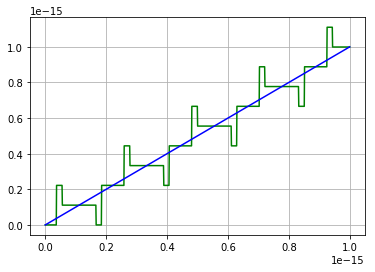

In [21]:
linset_x = np.linspace(0, 1e-15, 1000)

plt.figure()
plt.plot(linset_x, f(linset_x), 'g-')
plt.plot(linset_x, new_f(linset_x), 'b-')
plt.grid()
plt.show()

Se aprecia que la función antigua (en verde) tiene valores discretos con un error considerable cuando se acerca al $0$, mientras que la nueva función (en azul) parece más continua. Por último podemos ver la diferencia existente entre las funciones.

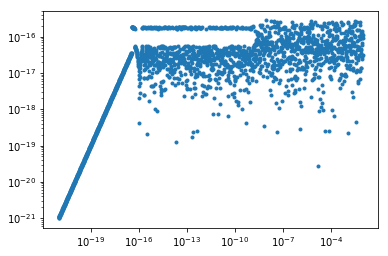

In [32]:
logset_x = np.logspace(-2, -21, 2000)
plt.loglog(logset_x, abs(f(logset_x) - new_f(logset_x)), '.')
plt.show()

---

#### 2. Para la siguiente función:

$$g(x) = \frac{1 - \sec(x)}{\tan(x)^2} $$

a) Usando $x = [0,\frac{\pi}{4} ,\frac{\pi}{2}, \frac{3\pi}{4} , ... , 2\pi ]$ (intervalo de $0$ a $2\pi$ ) calcule los valores de esta función. Realice el mismo procedimiento del punto anterior.

---

/home/vlizana/cc/CC/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


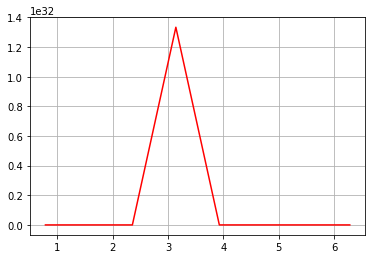

In [22]:
g = lambda x: ( 1 - (1/np.cos(x)) )/( np.tan(x) ** 2 )
set_x = np.linspace(0, 2 * np.pi, 9)
set_y = g(set_x)

plt.plot(set_x, set_y, 'r-')
plt.grid()
plt.show()

De partida el warning nos muestra que la función original se indefine en $x=0$, además casi todos los valores están muy cerca de $0$. Si nos acercamos mas podemos apreciar un poco mejor la diferencia.

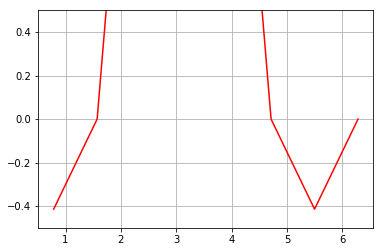

In [23]:
plt.plot(set_x, set_y, 'r-')
plt.ylim(-0.5, 0.5)
plt.grid()
plt.show()

Aparte si acercamos y graficamos con más puntos vemos que se puede ver que se pierde presición en los bordes, debido a que toma el valor $0$ en $x = 2k\pi$ (en donde debería indefinirse). También se indefine en $x=(2k-1)\pi$.

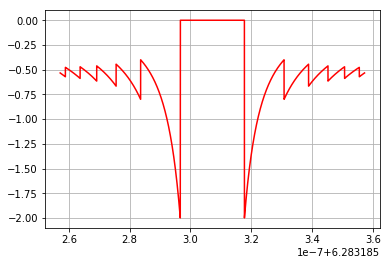

In [24]:
set_x = np.linspace(2 * np.pi - 5e-8, 2 * np.pi + 5e-8, 10001)
set_y = g(set_x)

plt.plot(set_x, set_y, 'r-')
plt.grid()
plt.show()

Los ceros reales de la función están ubicados en donde $\cos (x) = 0$, es decir, $x = \big( k + \frac{1}{2} \big) \pi$.

---

In [25]:
set_x = np.linspace(0, 2 * np.pi, 9)
set_y = g(set_x)

print(set_x, set_y, sep='\n')

[ 0.          0.78539816  1.57079633  2.35619449  3.14159265  3.92699082
  4.71238898  5.49778714  6.28318531]
[             nan  -4.14213562e-01  -6.12323400e-17   2.41421356e+00
   1.33354689e+32   2.41421356e+00   1.83697020e-16  -4.14213562e-01
   0.00000000e+00]


/home/vlizana/cc/CC/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


La pérdida de significancia ocurre cuando estamos muy cerca de $x=2k\pi$, en donde se indefine la función. El origen es la resta del numerador, ya que un número lo suficientemente pequeño es despreciable frente al 1.

In [26]:
x = 2 * np.pi - 1e-10
print('          x :', to_binary(x))
print('     sec(x) :', to_binary(1/np.cos(x)))
print(' 1 - sec(x) :', to_binary(1-(1/np.cos(x))))
print('tan(x) ** 2 :', to_binary(np.tan(x)**2))
print()
print('       g(x) :', to_binary(g(x)))

          x : 0 10000000001 1001001000011111101101010100010000100111010101001010
     sec(x) : 0 01111111111 0000000000000000000000000000000000000000000000000000
 1 - sec(x) : 0 00000000000 0000000000000000000000000000000000000000000000000000
tan(x) ** 2 : 0 01110111100 0111100111001010100011100010101010000110100011010100

       g(x) : 0 00000000000 0000000000000000000000000000000000000000000000000000


La pérdida de significancia ocurre cuando la secante se acerca mucho a 1:

$$ \sec(x) < 1 + \frac{\epsilon_{mach}}{2} \quad \Rightarrow \quad x > \cos^{-1}\bigg(\frac{2}{2+\epsilon_{mach}}\bigg) $$

In [27]:
x_teo = 1.053671259064442e-08
x = 2 * np.pi + x_teo
print('          x :', to_binary(x))
print('     sec(x) :', to_binary(1/np.cos(x)))
print(' 1 - sec(x) :', to_binary(1-(1/np.cos(x))))
print('tan(x) ** 2 :', to_binary(np.tan(x)**2))
print()
print('       g(x) :', to_binary(g(x)), end='\n\n')

x = x * (1 - e_mach)
print('          x :', to_binary(x))
print('     sec(x) :', to_binary(1/np.cos(x)))
print(' 1 - sec(x) :', to_binary(1-(1/np.cos(x))))
print('tan(x) ** 2 :', to_binary(np.tan(x)**2))
print()
print('       g(x) :', to_binary(g(x)))

print()
print('momento de pérdida de significancia: x = 2kπ ±', x_teo)

          x : 0 10000000001 1001001000011111101101010100111110010011001000001100
     sec(x) : 0 01111111111 0000000000000000000000000000000000000000000000000001
 1 - sec(x) : 1 01111001011 0000000000000000000000000000000000000000000000000000
tan(x) ** 2 : 0 01111001010 0000000000000000000000010111100101100100000110010110

       g(x) : 1 01111111111 1111111111111111111111010000110100110111110100011010

          x : 0 10000000001 1001001000011111101101010100111110010011001000001010
     sec(x) : 0 01111111111 0000000000000000000000000000000000000000000000000000
 1 - sec(x) : 0 00000000000 0000000000000000000000000000000000000000000000000000
tan(x) ** 2 : 0 01111001001 1111111111111111111101111010001001111001000001110011

       g(x) : 0 00000000000 0000000000000000000000000000000000000000000000000000

momento de pérdida de significancia: x = 2kπ ± 1.053671259064442e-08


---

Se puede reescribir la función de la siguiente manera:

$$ g(x) = \frac{1 - \sec(x)}{\sec^2(x) - 1} $$

$$ g(x) = \frac{-1}{1 + \sec(x)} $$

$$ g(x) = \frac{-\cos(x)}{1 + \cos(x)} $$

---

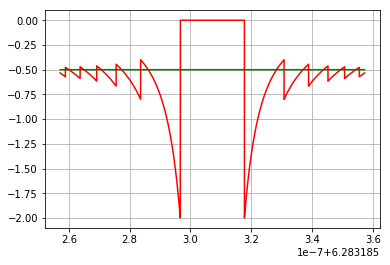

In [28]:
set_x = np.linspace(2 * np.pi - 5e-8, 2 * np.pi + 5e-8, 10001)
set_y = g(set_x)

new_g = lambda x: (-np.cos(x)) / (1 + np.cos(x))
new_set_y = new_g(set_x)

plt.plot(set_x, set_y, 'r-')
plt.plot(set_x, new_set_y, 'g-')
plt.grid()
plt.show()

Podemos ver como en este intervalo crítico se anula la pérdida de significancia y además, nuestra nueva función posee menos discontinuidades. Por último la diferencia entre las funciones.

/home/vlizana/cc/CC/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


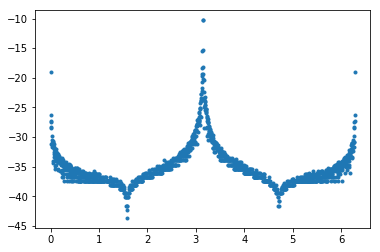

In [47]:
final_linset_x = np.linspace(0.0001, 2 * np.pi - 0.0001, 2000)
plt.plot(final_linset_x, np.log(abs(g(final_linset_x) - new_g(final_linset_x))), '.')
plt.show()

## Conclusiones
---

Podemos ver que es importante tener en cuenta que la representación de la función importa, ya que estamos forzando el orden de las operaciones y se puede perder significancia. Conocer la representación de punto flotante nos permite prevenir estos errores o al menos saber cuando y donde pueden ocurrir.

## Referencias
---

[Wolfram Alpha](www.wolframalpha.com)